In [1]:
import random

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
data = torch.cat([torch.sin((torch.arange(0, 50, 0.1)+ i*0.1)[None]) for i in range(64)], dim=0).T

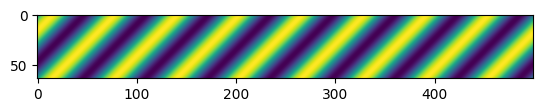

In [3]:
plt.imshow(data.T)

In [4]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(64, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 64)

    def forward(self, input, future = 0):
        B, T, D = input.size()

        outputs = []
        h_t = torch.zeros(B, 51, dtype=torch.float, device=input.device)
        c_t = torch.zeros(B, 51, dtype=torch.float, device=input.device)
        h_t2 = torch.zeros(B, 51, dtype=torch.float, device=input.device)
        c_t2 = torch.zeros(B, 51, dtype=torch.float, device=input.device)

        for input_t in input.split(1, dim=1):
            input_t = input_t.squeeze(1)

            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            output = output[:,None,:]

            outputs += [output]

        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output.squeeze(1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)

            output = output[:,None,:]

            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [5]:
# Create the sequence model and put it on GPU
model = Sequence().cuda()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Set the length of the sequences and the number of sequences to sample
sequence_length = 20
BS = 64

# Training loop
num_iterations = 10_000
for i in range(num_iterations):
    # Randomly sample starting indices for the sequences
    start_indices = random.sample(range(data.size(0) - (sequence_length + 1)), BS)
    # Extract the sequences
    sampled_sequences = torch.stack([data[start_idx:start_idx + (sequence_length + 1)] for start_idx in start_indices])

    x = sampled_sequences[:,:-1]
    y = sampled_sequences[:,1:]

    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(x.cuda())
    
    # Compute loss
    loss = criterion(output, y.cuda())
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 100 == 0:
        print(f'Iteration [{i + 1}/{num_iterations}], Loss: {loss.item():.6f}')

Iteration [100/10000], Loss: 0.063661
Iteration [200/10000], Loss: 0.023630
Iteration [300/10000], Loss: 0.015773
Iteration [400/10000], Loss: 0.011009
Iteration [500/10000], Loss: 0.007627
Iteration [600/10000], Loss: 0.005410
Iteration [700/10000], Loss: 0.003642
Iteration [800/10000], Loss: 0.002461
Iteration [900/10000], Loss: 0.001667
Iteration [1000/10000], Loss: 0.001119
Iteration [1100/10000], Loss: 0.000761
Iteration [1200/10000], Loss: 0.000520
Iteration [1300/10000], Loss: 0.000385
Iteration [1400/10000], Loss: 0.000271
Iteration [1500/10000], Loss: 0.000213
Iteration [1600/10000], Loss: 0.000167
Iteration [1700/10000], Loss: 0.000136
Iteration [1800/10000], Loss: 0.000111
Iteration [1900/10000], Loss: 0.000091
Iteration [2000/10000], Loss: 0.000078
Iteration [2100/10000], Loss: 0.000071
Iteration [2200/10000], Loss: 0.000062
Iteration [2300/10000], Loss: 0.000056
Iteration [2400/10000], Loss: 0.000049
Iteration [2500/10000], Loss: 0.000045
Iteration [2600/10000], Loss: 0.00

In [6]:
data.shape

torch.Size([500, 64])

In [7]:
new_input = data[-sequence_length:]
new_input.shape

torch.Size([20, 64])

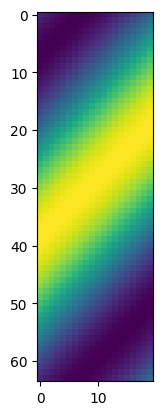

In [8]:
plt.imshow(new_input.T)

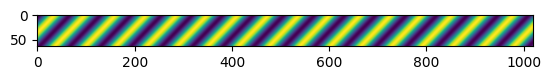

In [13]:
plt.imshow(model(new_input[None].cuda(), future=1000).cpu().detach().numpy().squeeze().T)